# Test Algorithms

By Anthony

# Load Data

In [1]:
from recom_system.algorithms.preprocessing import get_ratings_datasets


trainset, testset = get_ratings_datasets(train_size=1, drop_zero=True)
print(f'{len(trainset.raw_ratings)=}, {len(testset)=}')


len(trainset.raw_ratings)=363099, len(testset)=0


In [2]:
type(trainset)

surprise.dataset.DatasetAutoFolds

In [3]:
type(testset)

numpy.ndarray

In [4]:
def get_best_rmse(gs):
    ind = gs.cv_results['params'].index(gs.best_params['rmse'])
    rmse_list = [gs.cv_results[f'split{i}_test_rmse'][ind]
                 for i in range(gs.cv)]
    return rmse_list
    

# Simple Collaborative Filtering 

## Baseline

In [5]:
from surprise import BaselineOnly
from surprise.model_selection import cross_validate

bl = BaselineOnly()
rmse_bl = cross_validate(bl, trainset, ['rmse'], cv=5)['test_rmse']

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [6]:
rmse_bl

array([0.83660741, 0.84195114, 0.84396108, 0.84140521, 0.84390871])

## SVD++

P value < 0.05, significantly better than Baseline.

In [7]:
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

params = {
    'n_factors': [10, 20, 50, 100],
    'n_epochs': [20,50]
}

gs_svd = GridSearchCV(SVDpp, params, ['rmse'], cv=5)
gs_svd.fit(trainset)
print(f'{gs_svd.best_params=}, {gs_svd.best_score=}')

gs_svd.best_params={'rmse': {'n_factors': 10, 'n_epochs': 20}}, gs_svd.best_score={'rmse': 0.8132215061738538}


In [8]:
svd = gs_svd.best_estimator['rmse']
rmse_svd = get_best_rmse(gs_svd)
rmse_svd

[0.8146200027489624,
 0.8172127646868833,
 0.808631607487773,
 0.8114388992765034,
 0.8142042566691474]

In [9]:
from scipy.stats import ttest_ind
ttest_ind(rmse_bl, rmse_svd)

TtestResult(statistic=14.254526522254828, pvalue=5.717430717204586e-07, df=8.0)

## Item-Based KNN

P value from T-Test > 0.05, no significant improvement comparing with Baseline.

In [10]:
from surprise import KNNWithMeans


params = {
    "k": [10, 20, 50, 100],
    "min_k": [1, 3, 5, 10],
    "sim_options": {
        "user_based": [False],
        "name": ["msd", "cosine"],
    },
    "verbose": [False],
}

gs_knn = GridSearchCV(KNNWithMeans, params, ['rmse'], cv=5)
gs_knn.fit(trainset)
print(f'{gs_knn.best_params=}, {gs_knn.best_score=}')

gs_knn.best_params={'rmse': {'k': 50, 'min_k': 3, 'sim_options': {'user_based': False, 'name': 'msd'}, 'verbose': False}}, gs_knn.best_score={'rmse': 0.8425375086483211}


In [11]:
knn = gs_knn.best_estimator['rmse']
rmse_knn = get_best_rmse(gs_knn)
rmse_knn

[0.8396249518778547,
 0.8430932263728895,
 0.8435954958025824,
 0.8460033611640593,
 0.8403705080242191]

In [12]:
ttest_ind(rmse_bl, rmse_knn)

TtestResult(statistic=-0.548702366692953, pvalue=0.5981852303434684, df=8.0)

# Simple Content-Based

In [5]:
from recom_system.algorithms.io import get_books

books = get_books()

In [6]:
import numpy as np


def summarize_n(algo, data, n=[5, 10, 15], measures=['ndcg', 'precision']):
    results = {n: [] for n in measures}
    for k in n:
        ms = [f'{name}@{k}' for name in measures]
        res = cross_validate(algo, data, measures=ms)
        for m in ms:
            results[m.split('@')[0]].append(np.mean(res[m]))
    return results

## Sentence Embeddings

Sentence Vectors from book's title and description

In [7]:
from recom_system.algorithms.models.vector_based.sentence_embeddings import build_item_matrix
from recom_system.algorithms.models.vector_based import VectorBasedModel
from recom_system.algorithms.metrics import cross_validate

sent_profiles = build_item_matrix(books)
sent_model = VectorBasedModel(sent_profiles)
sent_result = summarize_n(sent_model, trainset)
sent_result

{'ndcg': [0.9781397963008651, 0.9807475160611581, 0.9812546519713733],
 'precision': [0.7519778949325999, 0.7513502243400039, 0.7512622764733645]}

## TF-IDF

TF-IDF from book's popular_shelves field

In [8]:
from recom_system.algorithms.models.dict_based.popular_shelves import build_item_profile
from recom_system.algorithms.models.dict_based import DictBasedModel
from recom_system.algorithms.metrics import cross_validate

shelf_profiles = build_item_profile(books)
shelf_model = DictBasedModel(shelf_profiles)
shelf_result = summarize_n(shelf_model, trainset)
shelf_result

{'ndcg': [0.977581343037258, 0.980255055815638, 0.9808054420397168],
 'precision': [0.7520201983227344, 0.7516508705490472, 0.7520681243194396]}

## Comparison

Sentence Embeddings is good at item ranking. And there is a great improvement of nDCG from k = 5 to k = 10. So we chose to show top 10 items to our users.

Text(0.5, 1.0, 'Precision@K')

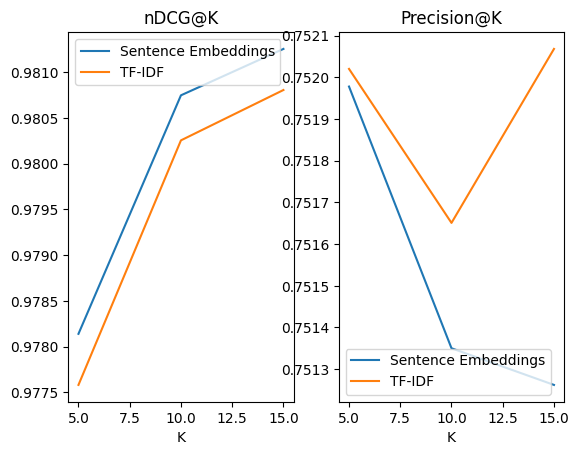

In [9]:
import numpy as np
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

x = [5, 10, 15]
ax1.plot(x, sent_result['ndcg'], label='Sentence Embeddings')
ax1.plot(x, shelf_result['ndcg'], label='TF-IDF')
ax1.legend()
ax1.set_xlabel('K')
ax1.set_title("nDCG@K")

ax2.plot(x, sent_result['precision'], label='Sentence Embeddings')
ax2.plot(x, shelf_result['precision'], label='TF-IDF')
ax2.legend()
ax2.set_xlabel('K')
ax2.set_title("Precision@K")

# Hybird Models

## User-Based KNN via Sentence Embeddings

In [7]:
from recom_system.algorithms.models.knn_via_content import KNNViaContent
from recom_system.algorithms.models.vector_based.sentence_embeddings import build_item_matrix
from recom_system.algorithms.metrics import cross_validate


sent_profiles = build_item_matrix(books)
knn_sent = KNNViaContent(sent_profiles)
results_knn_sent = cross_validate(knn_sent, trainset, ['rmse', 'ndcg@10', 'precision@10', 'recall@10'], cv=5)
results_knn_sent

{'rmse': [0.9062392418936636,
  0.9051320720251514,
  0.9104927361718672,
  0.9035830088797426,
  0.9055446518434431],
 'ndcg@10': [0.9820154988927444,
  0.9820500268259471,
  0.9819178024787244,
  0.9822604938195173,
  0.981991950424177],
 'precision@10': [0.7528404712540343,
  0.7535294450336152,
  0.7489880224540012,
  0.7513425240815347,
  0.7497218985959924],
 'recall@10': [0.8626349983107585,
  0.8618209138513918,
  0.8593780076839971,
  0.8608993937760451,
  0.8581943828645248]}

In [9]:
# compare with sentence embeddings content based
from recom_system.algorithms.models.vector_based.sentence_embeddings import build_item_matrix
from recom_system.algorithms.models.vector_based import VectorBasedModel
from recom_system.algorithms.metrics import cross_validate

sent_profiles = build_item_matrix(books)
sent_model = VectorBasedModel(sent_profiles)
results_sent = cross_validate(sent_model, trainset, ['rmse', 'ndcg@10', 'precision@10', 'recall@10'], cv=5)

In [10]:
results_sent

{'rmse': [272.6610581571527,
  15390.502145556502,
  247.5017384542953,
  261.6702656067209,
  695.701952164257],
 'ndcg@10': [0.9807999441730565,
  0.980854375032268,
  0.9804341472509249,
  0.9805814549490941,
  0.9806651252493114],
 'precision@10': [0.7510344125917456,
  0.7512364640278495,
  0.752114688733518,
  0.7519463991839506,
  0.7522640445283957],
 'recall@10': [0.8597514186266361,
  0.8607140424467848,
  0.8610631240205002,
  0.8617077271089457,
  0.8611036608863691]}

In [12]:
from scipy.stats import ttest_ind

ttest_ind(results_knn_sent['ndcg@10'], results_sent['ndcg@10'])

TtestResult(statistic=14.522660901112737, pvalue=4.950206757240847e-07, df=8.0)

In [13]:
ttest_ind(results_knn_sent['precision@10'], results_sent['precision@10'])

TtestResult(statistic=-0.4802750259496822, pvalue=0.6438894519377525, df=8.0)

In [14]:
ttest_ind(results_knn_sent['recall@10'], results_sent['recall@10'])

TtestResult(statistic=-0.32539395038549085, pvalue=0.7532301619877556, df=8.0)

Text(0.5, 1.0, 'Precision@10')

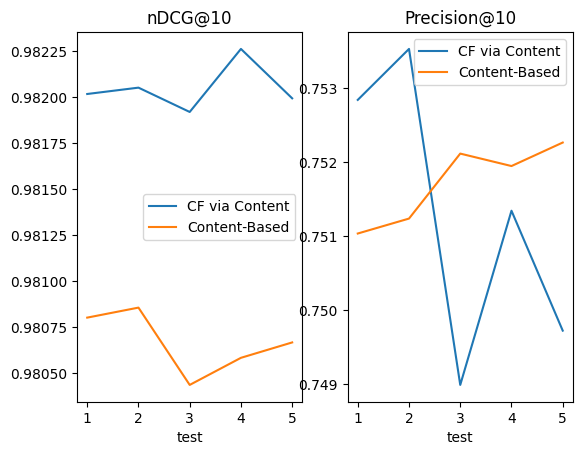

In [16]:
from matplotlib import pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2)

x = [i + 1 for i in range(5)]
ax1.plot(x, results_knn_sent['ndcg@10'], label='CF via Content')
ax1.plot(x, results_sent['ndcg@10'], label='Content-Based')
ax1.legend()
ax1.set_xlabel('test')
ax1.set_title("nDCG@10")

ax2.plot(x, results_knn_sent['precision@10'], label='CF via Content')
ax2.plot(x, results_sent['precision@10'], label='Content-Based')
ax2.legend()
ax2.set_xlabel('test')
ax2.set_title("Precision@10")

## NCF after SVD

In [ ]:
from recom_system.algorithms.models.svd_nn import SvdNCF

svdncf = SvdNCF(svd_params={'n_factors': 10, 'n_epochs': 20},
                ncf_params={'in_features': 20, 'out_features': 1}, fit_and_train=True)
results_svdncf = cross_validate(svdncf, trainset, ['rmse', 'ndcg@10', 'precision@10', 'recall@10'], cv=5)

2024-04-24 23:22:33.510632: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 23:22:34.297219: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
20/20: 100%|███████████████████████████████| 3631/3631 [00:10<00:00, 351.72it/s]
/home/anthony/code/lucky-passbook/recom_system/algorithms/models/svd_nn.py:100: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  features = torch.Tensor(features)
5/20:  93%|█████████████████████████████▊  | 3389/3631 [00:09<00:00, 337.44it/s]

In [ ]:
results_svdncf

## Uniform-Weighted Hybird

In [2]:
from surprise import SVDpp, KNNWithMeans
from recom_system.algorithms.models.weighted_model import WeightedModel
from recom_system.algorithms.metrics import cross_validate


uwm = WeightedModel([
    KNNWithMeans(k=50, min_k=3, verbose=False, sim_options={'user_based': False, 'name': 'cosine'}),
    SVDpp(n_factors=10, n_epochs=20),
], auto_weight=0)
results_uwm = cross_validate(uwm, trainset, ['rmse', 'ndcg@5', 'precision@5', 'recall@5'], cv=5)
results_uwm


{'rmse': [0.8119705754486285,
  0.8136854771061794,
  0.816071445163903,
  0.8110131419909373,
  0.8192690751128034],
 'ndcg@5': [0.983772537158829,
  0.9837749193092014,
  0.983571045541635,
  0.9838502732989562,
  0.983667931011066],
 'precision@5': [0.7546035408761096,
  0.7517173150143116,
  0.754564432558894,
  0.755320568065569,
  0.7540905480097652],
 'recall@5': [0.846039724772004,
  0.8425876371779866,
  0.8437066460666679,
  0.8448265805919627,
  0.8447102295607204]}

In [3]:
print(uwm.weights)

[0.5 0.5]


## Auto-Weighted Hybird



In [4]:
from surprise import SVDpp, KNNWithMeans
from recom_system.algorithms.models.weighted_model import WeightedModel
from recom_system.algorithms.metrics import cross_validate


awm = WeightedModel([
    KNNWithMeans(k=50, min_k=3, verbose=False, sim_options={'user_based': False, 'name': 'cosine'}),
    SVDpp(n_factors=10, n_epochs=20),
], auto_weight=10000, fixed=True)
results_awm = cross_validate(awm, trainset, ['rmse', 'ndcg@5', 'precision@5', 'recall@5'], cv=5)
results_awm


{'rmse': [0.8118343447356886,
  0.8169967104015143,
  0.8132371941324894,
  0.8139507569441877,
  0.8099094991907149],
 'ndcg@5': [0.9837431500725241,
  0.9835721968202616,
  0.9833830139237109,
  0.9839412106374488,
  0.9837523128232181],
 'precision@5': [0.7556742615006378,
  0.7507511347225748,
  0.75224321332881,
  0.7540382577409174,
  0.7573610153469842],
 'recall@5': [0.8468302395131304,
  0.8424240344230922,
  0.8433875805106404,
  0.8441952065320927,
  0.8440934586008085]}

In [5]:
print(awm.weights)

[0.00173455 0.9999282 ]


## Dynamic-Weighted Hybird

In [ ]:
from surprise import SVDpp, KNNWithMeans
from recom_system.algorithms.models.weighted_model import WeightedModel
from recom_system.algorithms.metrics import cross_validate


dwm = WeightedModel([
    KNNWithMeans(k=50, min_k=3, verbose=False, sim_options={'user_based': False, 'name': 'cosine'}),
    SVDpp(n_factors=10, n_epochs=20),
], auto_weight=1000, fixed=False)
results_dwm = cross_validate(dwm, trainset, ['rmse', 'ndcg', 'precision', 'recall'], cv=5)
results_dwm
